# Demonstration of Leapfrog Optimizer

This notebook tests the Leapfrog optimizer by Mark Redd:

- [lpfgopt](https://github.com/flythereddflagg/lpfgopt) (2020)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from dataclasses import dataclass

import lpfgopt
lpfgopt.__version__

'1.0.1'

In [2]:
from platform import python_version
python_version()

'3.10.18'

## Optimization Problem Definition

In [3]:
@dataclass
class ConstrainedScalarOptimizationProblem():
    _guesses: list
    _input_shape: tuple
    _bounds: np.ndarray
    _global_minimum: np.ndarray

    def __init__(self, bounds, global_minimum=None):
        self._bounds = bounds
        self._input_shape = bounds.shape[:-1]
        self._global_minimum = global_minimum
        self.reset()

    def reset(self):
        self._guesses = []

    @property
    def input_shape(self) -> tuple:
        return self._input_shape

    @property
    def bounds(self) -> np.ndarray:
        return self._bounds

    @property
    def global_minimum(self) -> np.ndarray:
        return self._global_minimum

    @property
    def nfev(self) -> int:
        return len(self._guesses)

    @property
    def guesses(self) -> list:
        return self._guesses

    @property
    def best_guess(self) -> tuple:
        return min(self._guesses)

    @staticmethod
    def cost_function_to_minimize(x, *args) -> float:
        # Implement cost function to minimize here
        cost = 0.0
        return cost

    def __call__(self, x, *args) -> float:
        assert np.all(self._bounds[:, 0] <= x)
        assert np.all(x <= self._bounds[:, 1])
        cost = self.cost_function_to_minimize(x, *args)
        self._guesses.append((cost, x))
        return cost


### 1. Toy 1D Problem

In [4]:
class Toy1DProblem(ConstrainedScalarOptimizationProblem):

    def __init__(self):
        bounds = np.array([[-5, 5]])
        super().__init__(bounds, global_minimum=[2.508538220648739])

    @staticmethod
    def cost_function_to_minimize(x, *args) -> float:
        return -(-0.05 * x[0] ** 2 - np.cos(x[0]) + 0.25 * np.sin(3 * x[0] + 0.8) + 5)


# Test problem instance
problem = Toy1DProblem()
assert str(problem) == (
    "Toy1DProblem(_guesses=[], _input_shape=(1,), _bounds=array([[-5,  5]]), "
    "_global_minimum=[2.508538220648739])"
)
assert np.array_equal(problem.bounds, [[-5,  5]])
assert problem.input_shape == (1, )
assert problem.nfev == 0
assert problem.guesses == []
assert problem([0.5]) == -4.296343741153807
assert problem.guesses == [(-4.296343741153807, [0.5])]
assert problem.nfev == 1
assert problem([-5]) == -3.2168311513576833
assert problem([5]) == -3.4433611019798533
assert problem.nfev == 3
assert problem.best_guess == (-4.296343741153807, [0.5])

# Find global minimum using Scipy and good initial guess
sol = scipy.optimize.minimize(problem, x0=2.5, bounds=problem.bounds, tol=1e-15)
assert sol.status == 0
print(sol.fun, sol.x.item())
assert np.array_equal(problem.global_minimum, sol.x)

-5.71429291939986 2.508538220648739


In [5]:
def solve_problem_with_optimizer(
    problem, minimizer, *args, **kwargs
):
    problem.reset()
    sol = minimizer(problem, *args, bounds=problem.bounds, **kwargs)
    return sol

rng = np.random.default_rng(0)
x0 = rng.uniform(problem.bounds[:, 0], problem.bounds[:, 1])
sol = solve_problem_with_optimizer(problem, scipy.optimize.minimize, x0)
sol

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -5.714292919392315
        x: [ 2.509e+00]
      nit: 4
      jac: [-6.661e-06]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

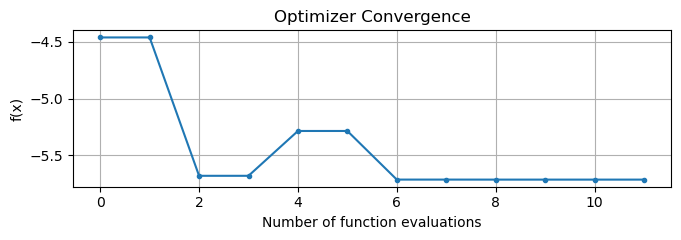

In [6]:
def convergence_plot(problem):
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.gca()
    plt.plot(np.array([item[0] for item in problem.guesses]), marker='.')
    plt.xlabel('Number of function evaluations')
    plt.ylabel('f(x)')
    plt.grid()
    plt.title('Optimizer Convergence')
    return ax

convergence_plot(problem)
plt.tight_layout()
plt.show()

In [7]:
solve_problem_with_optimizer(problem, lpfgopt.minimize)

        best: [np.float64(-5.714292919399852), np.float64(2.50853815506143)]
 final_error: np.float64(9.658409291675885e-06)
         fun: np.float64(-5.714292919399852)
       maxcv: 0
     message: 'Tolerance condition satisfied'
        nfev: 284
         nit: 264
    pointset: [[np.float64(-5.714292919396341), np.float64(2.5085366732830545)], [np.float64(-5.714292919399852), np.float64(2.50853815506143)], [np.float64(-5.71429291939317), np.float64(2.5085403723388575)], [np.float64(-5.714292919398472), np.float64(2.5085372520442166)], [np.float64(-5.714292919396996), np.float64(2.508536825479019)], [np.float64(-5.7142929193995045), np.float64(2.5085387221067617)], [np.float64(-5.714292919393813), np.float64(2.5085402665324534)], [np.float64(-5.714292919393545), np.float64(2.5085361450607846)], [np.float64(-5.714292919397118), np.float64(2.508536855704436)], [np.float64(-5.714292919391821), np.float64(2.508540578541245)], [np.float64(-5.714292919399835), np.float64(2.5085380987390593

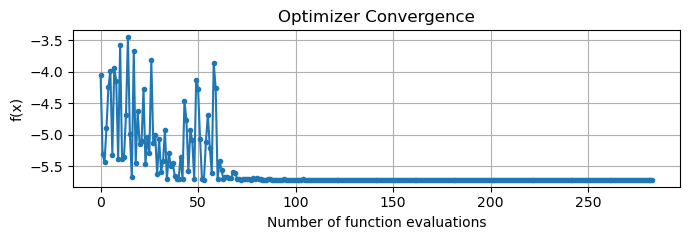

In [8]:
convergence_plot(problem)
plt.tight_layout()
plt.show()

In [9]:


X = np.linspace(-5, 5, 100).reshape(1, -1)
Y = function_to_minimize(X)

# Compute minimum numerically
sol = minimize(function_to_minimize, x0=[2])
assert sol.status == 0
min_pt = np.array([sol.x[0], sol.fun])

plt.plot(X.T, Y.T)
plt.plot(*min_pt, 'ko')
plt.annotate(f'Min: {min_pt.round(3)}', min_pt, xytext=(10, 0),
             textcoords='offset points', va='center')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function to minimize')
plt.grid()

NameError: name 'function_to_minimize' is not defined

Solution: [ 2.509 -5.714]


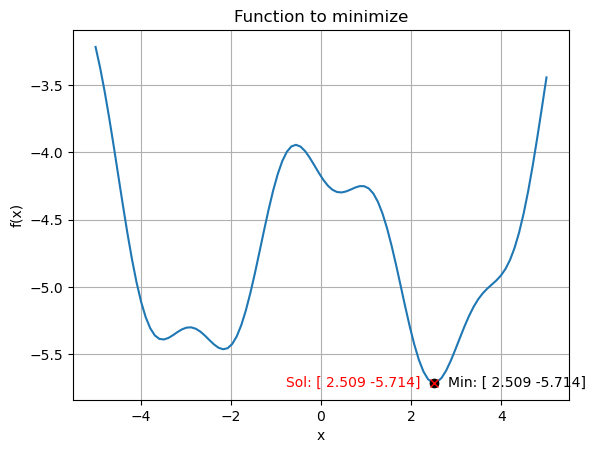

In [ ]:
# Define bounded region of parameter space
bounds = [(-5, 5)]

# Run optimizer
# run the optimization
sol = lpfgopt.minimize(function_to_minimize, bounds)
assert sol.status == 0
sol_pt = np.array([sol['x'][0], sol['fun'][0]])
print(f"Solution: {sol_pt.round(3)}")

plt.plot(X.T, Y.T)
plt.plot(*min_pt, 'ko')
plt.annotate(f'Min: {min_pt.round(3)}', min_pt, xytext=(10, 0),
             textcoords='offset points', va='center')
plt.plot(*sol_pt, 'rx')
plt.annotate(f'Sol: {sol_pt.round(3)}', sol_pt, xytext=(-10, 0),
             textcoords='offset points', ha='right', va='center', color='r')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function to minimize')
plt.grid()

## Check repeatability

In [ ]:
from collections import Counter

Counter([round(lpfgopt.minimize(function_to_minimize, bounds)['x'][0], 3) for _ in range(100)])

Counter({2.509: 91, -2.159: 8, -3.512: 1})